### HW 3-2. DDPG for Traffic Light Control

Please write down the codes for DDOG algorithm on this file. Also, add your comment with the result here,

## Import Libraries and check for GPU

In [1]:
### DDPG ###
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import math
import random
import numpy as np

from itertools import count
from collections import namedtuple

CUDA = True

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() and CUDA else "cpu")
print(device)

cuda


##  Import Traci and other SUMO's tools

In [2]:
import os, sys
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

## Define Transitions and Replay Memory

In [3]:
Transition = namedtuple('Transition',('before_state', 'action', 'reward', 'state', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

##  Ornstein-Uhlenbeck process

In [4]:
class OUStrategy:
    """
    From vithyer/rlkit
    """

    def __init__(self, action_space, mu=0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu = mu
        self.theta = theta
        self.sigma = max_sigma
        self._max_sigma = max_sigma
        self._min_sigma = min_sigma
        self._decay_period = decay_period
        self.dim = action_space
        self.reset()
        
        self.epsilon = 0.9
        self.epsilon_min = 0.005
        self.decay_rate = 0.005

    def reset(self):
        self.state = np.ones(self.dim) * self.mu

    def evolve_state(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

    def get_action_from_raw_action(self, action, t=0):
        ou_state = self.evolve_state() * self.epsilon
        
        self.epsilon -= self.decay_rate
        self.epsilon = self.epsilon_min if self.epsilon < self.epsilon_min else self.epsilon
        
        self.sigma = (
            self._max_sigma
            - (self._max_sigma - self._min_sigma)
            * min(1.0, t * 1.0 / self._decay_period)
        )
        return np.clip(action + ou_state, -1.0, 1.0)

## Networks

### 1. Critic Network

In [5]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=20):
        super(Critic, self).__init__()
        self.action_dim = action_dim
        self.state_dime = state_dim
        
        self.h1 = nn.Linear(state_dim, hidden_dim)
        self.h2 = nn.Linear(hidden_dim + action_dim, hidden_dim)
        
        self.head = nn.Linear(hidden_dim, 1)
        
    def forward(self, state, action):
        x = F.relu(self.h1(state))
        x = F.relu(self.h2(torch.cat([x, action], dim=-1)))
        return self.head(x)

### 2. Actor Network

In [6]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=[64, 64]):
        super(Actor, self).__init__()
        
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()
        
        input_dims = [state_dim] + hidden_dim
        output_dims = hidden_dim + [action_dim]
        
        [self.layers.append(nn.Linear(i,o)) for i, o in zip(input_dims, output_dims)]
        [self.activations.append(nn.LeakyReLU()) for _ in hidden_dim]
        
        self.activations.append(nn.Tanh())
        
    def forward(self, x):
        x = x.clone()
        for lay, act in zip(self.layers, self.activations):
            x = act(lay(x))
        return x

## DDPG Agent

In [7]:
class DDPGAgent(nn.Module):
    def __init__(self, state_dim, action_dim, action_min, action_max):
        super(DDPGAgent, self).__init__()
        
        self.critic = Critic(state_dim, action_dim).to(device)
        self.target_critic = Critic(state_dim, action_dim).to(device)
        
        
        self.actor = Actor(state_dim, action_dim).to(device)
        self.target_actor = Actor(state_dim, action_dim).to(device)

        self.memory = ReplayMemory(2**12)

        self.critic_optim = optim.Adam(self.critic.parameters(), lr=1e-4)
        self.actor_optim  = optim.Adam(self.actor.parameters(), lr=1e-4)
        
        self.batch_size = 128
        self.gamma = 0.999
        self.target_update = 3000
        
        self.critic_loss = nn.MSELoss()
        
        self.OU = OUStrategy(action_dim)
        
        
        self.action_min = action_min
        self.action_max = action_max
        
        self.num_train = 0
    
    def forward(self, state, step=0):
        raw_action = None
        with torch.no_grad():
            raw_action =  self.actor(state).detach().cpu().numpy()
        
        action = self.OU.get_action_from_raw_action(raw_action, step)
        norm_action = (action + 1) / 2 * (self.action_max - self.action_min) + self.action_min
        return action, norm_action
    
    def train(self):
        self.num_train += 1
        transitions = self.memory.sample(self.batch_size)
        # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
        # detailed explanation). This converts batch-array of Transitions
        # to Transition of batch-arrays.
        batch = Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.state if s is not None])
        
        state_batch = torch.cat(batch.before_state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        q = self.critic(state_batch, action_batch).squeeze(1)
        
        y = torch.zeros(self.batch_size, device=device)
        y[non_final_mask] = self.gamma * self.target_critic(non_final_next_states, self.target_actor(non_final_next_states)).squeeze(1)
        y += reward_batch
        
        # Compute Critic loss
        critic_loss = self.critic_loss(q, y)
        
        # Optimize the Critic model
        self.critic_optim.zero_grad()
        critic_loss.backward()
        
        for param in self.critic.parameters():
            param.grad.data.clamp_(-1, 1)
        self.critic_optim.step()
        
        # Compute Actor loss
        actor_loss = -self.critic(state_batch, self.actor(state_batch))
        actor_loss = actor_loss.mean()
              
        # Optimize the Actor model
        self.actor_optim.zero_grad()
        actor_loss.backward()
        
        for param in self.actor.parameters():
            param.grad.data.clamp_(-1, 1)
        self.actor_optim.step()
        
#         print(self.num_train)
        if self.num_train % self.target_update == 0:
            self.update_target()        
        
        return actor_loss.item(), critic_loss.item()
    
    def train_start(self):
        return len(self.memory) > self.batch_size # Boolean
    
    def update_target(self):
        print('UPDATED')
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_actor.eval()
        
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_critic.eval()
    
    
    
    
    def save_memory(self, transition):
        transition[1] = torch.tensor(transition[1], device=device, dtype=torch.float)
        transition[2] = torch.tensor([transition[2]], device=device)
        self.memory.push(*transition)
    

In [8]:
### Training (Do not revise this code)###
from SUMO.TrafficEnv_DDPG import TrafficEnv

import torch
import random
import numpy as np
import matplotlib.pyplot as plt

def main_DDPG() :

    exp_dir = './SUMO/Single_Intersection'
    exp_type = 'binary'

    max_episode = 300
    max_epi_step = 800

    state_dim = 12
    action_dim = 1

    action_min = 5
    action_max = 20

    env = TrafficEnv(exp_dir, exp_type)
    agent = DDPGAgent(state_dim, action_dim, action_min, action_max)

    actor_loss_list = []
    critic_loss_list = []
    reward_list = []

    for episode in range(max_episode):

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).reshape(-1, state_dim)

        actor_loss_epi = []
        critic_loss_epi = []
        reward_epi = []
        timing_data_epi = []
        action = None
        step = 0
        current_phase = 0

        for epi_step in range(max_epi_step):

            # make an action based on epsilon greedy action
            before_action = action

            action, action_norm = agent.forward(state, step)

            before_state = state

            state, reward, done = env.step(action_norm)

            state = torch.tensor(state, dtype=torch.float32, device=device).reshape(-1, state_dim)
            reward_epi.append(reward)

            # make a transition and save to replay memory
            transition = [before_state, action, reward, state, done]
            agent.save_memory(transition)

            if agent.train_start():
                critic_loss, actor_loss = agent.train()

                critic_loss_epi.append(critic_loss)
                actor_loss_epi.append(actor_loss)

            if done:
                if agent.train_start():
                    critic_mean = sum(critic_loss_epi) / len(critic_loss_epi)
                    actor_mean = sum(actor_loss_epi) / len(actor_loss_epi)
                    
                    critic_loss_list.append(critic_mean)
                    actor_loss_list.append(actor_mean)
                break

            step += 1

        reward_list.append(sum(reward_epi))  
    
        env.close()

        print(episode+1, reward_list[-1])

    return critic_loss_list, actor_loss_list, reward_list

if __name__ == "__main__":

    critic_loss_list, actor_loss_list, reward_list = main_DDPG()

    plt.plot(critic_loss_list)
    plt.title("Critic Loss of DDPG Agent")
    plt.savefig("./Visualization/DDPG/critic_loss.png")
    plt.close('all')
    
    plt.plot(actor_loss_list)
    plt.title("Actor Loss of DDPG Agent")
    plt.savefig("./Visualization/DDPG/actor_loss.png")
    plt.close('all')

    plt.plot(reward_list)
    plt.title("Reward of DDPG Agent")
    plt.savefig("./Visualization/DDPG/reward.png")
    plt.close('all')


 Retrying in 1 seconds
1 -159
 Retrying in 1 seconds
2 -136
 Retrying in 1 seconds
3 -147
 Retrying in 1 seconds
4 -144
 Retrying in 1 seconds
5 -488
 Retrying in 1 seconds
6 -436
 Retrying in 1 seconds
7 -125
 Retrying in 1 seconds
8 -112
 Retrying in 1 seconds
9 -112
 Retrying in 1 seconds
10 -107
 Retrying in 1 seconds
11 -105
 Retrying in 1 seconds
12 -106
 Retrying in 1 seconds
13 -95
 Retrying in 1 seconds
14 -103
 Retrying in 1 seconds
15 -96
 Retrying in 1 seconds
16 -101
 Retrying in 1 seconds
17 -95
 Retrying in 1 seconds
18 -92
 Retrying in 1 seconds
19 -94
 Retrying in 1 seconds
20 -106
 Retrying in 1 seconds
21 -96
 Retrying in 1 seconds
22 -104
 Retrying in 1 seconds
23 -100
 Retrying in 1 seconds
24 -100
 Retrying in 1 seconds
25 -86
 Retrying in 1 seconds
26 -100
 Retrying in 1 seconds
27 -100
 Retrying in 1 seconds
28 -90
 Retrying in 1 seconds
29 -89
 Retrying in 1 seconds
30 -95
 Retrying in 1 seconds
31 -97
 Retrying in 1 seconds
32 -100
 Retrying in 1 seconds
33 -8

# Results
--------

## Reward

First I show the result of reward improvement and compare it to naive strategies (random, always 5(min) and always max(20))

This comparision shows learning process improved the reward compared to complete random and always 5, but at the end DDPG reward is almost same with always 20, sometimes slightly better or worse.

## Loss

Unlike supervised learning, the RL will not converge when loss decrease to zero, the loss value is just shows the diffrence between target network and current network.

In DDPG, there are two loss values: 

1. **Critic Loss**: Like DQN is shows diffrence of target and current. This loss help to learn a better target network which is closer to real Q Function.

2. **Actor Loss**: This loss is actually the mean of negetive critic rewards, by minimizing this loss we actully trained the network to generate actions which maximise critic reward and by assuming the critic is a good aproximation of true Q Function, this leads to choosing best action which maximise expected payoff.


In general optimizer tries to reducde this loss, but we can see a jump in loss function every time we updated the target value.

I tried diffrent parameter for batch size and how often update the target nerwork, I found the reward might increase more stable if loss value bound inside a range and do not increase with every update. Intiutivily we should not update the target value too fast and let optimizer decrease the loss fucntion. 

--------


### Rewards:

1. Random: Randomly choose between **min** and **max**: [5, 20]
2. Always Min: 5
3. Always Max: 20
4. DDPG Agent (Not Tuned)
5. DDPG Agent (Tuned)

As shows in below DDPG improved form -150 to -92.

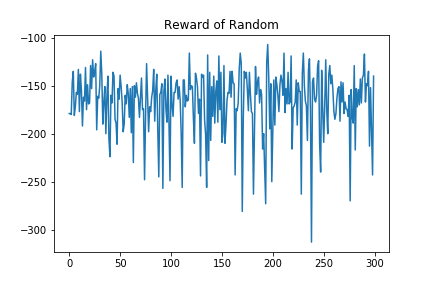

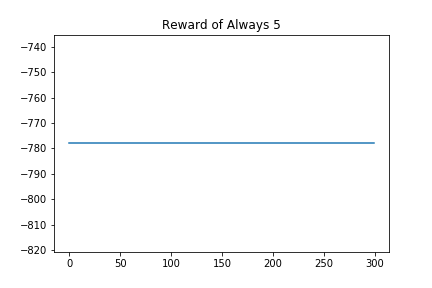

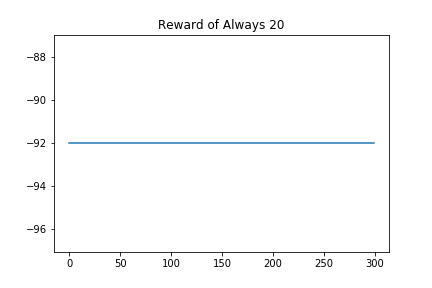

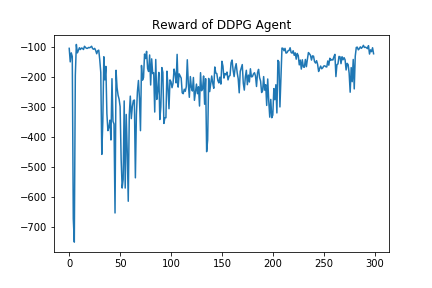

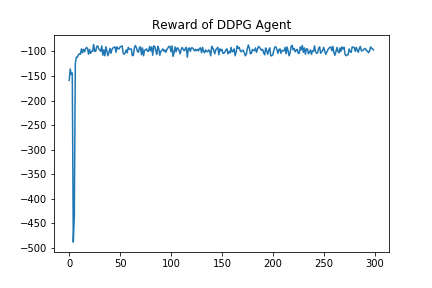

[None, None, None, None, None]

In [15]:
from IPython.display import Image, display

[display(Image(filename='./Visualization/DDPG/reward' + img + '.png')) for img in ['_random', '_five', '_20', '2', '_gpu']] 

### Learning Loss

1. Batch: 100 - Update Target every: 1500 steps (*Not Tuned*)
2. Batch: 128 - Update Target every: 3000 steps (*Tuned: Better Result* ) 

Overall, the loss function value does not have an important meaning we should just see it decreases in a prieod till we update the target network.
The second set

#### Actor's Loss

1. Batch: 100 - Update Target every: 1500 steps (*Not Tuned*)
2. Batch: 128 - Update Target every: 3000 steps (*Tuned: Better Result* ) 

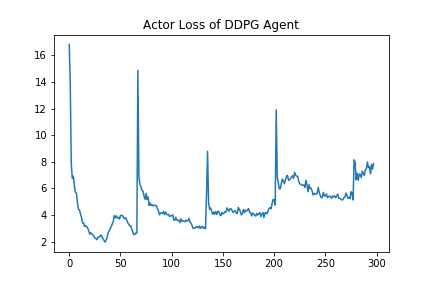

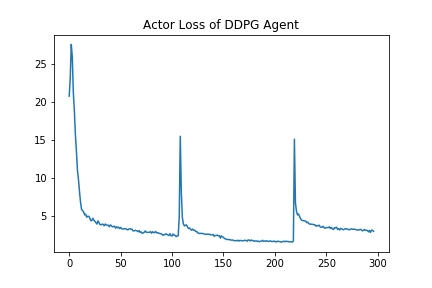

[None, None]

In [16]:
## Results of Actors
from IPython.display import Image, display

[display(Image(filename='./Visualization/DDPG/actor_' + img + '.png')) for img in ['loss2', 'loss_gpu']] 

#### Critic's Loss

1. Batch: 100 - Update Target every: 1500 steps (*Not Tuned*)
2. Batch: 128 - Update Target every: 3000 steps (*Tuned: Better Result* ) 

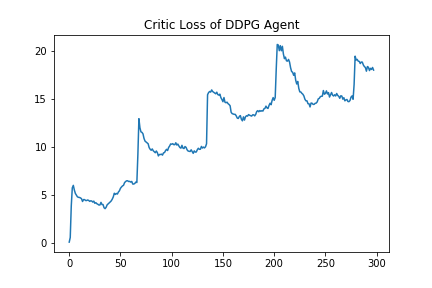

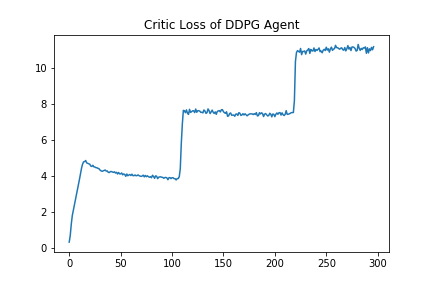

[None, None]

In [17]:
## Results
from IPython.display import Image, display

[display(Image(filename='./Visualization/DDPG/critic_' + img + '.png')) for img in ['loss2', 'loss_gpu']] 